# Setup

In [ ]:
import torch
from torchvision import datasets, transforms 
from sklearn.metrics import classification_report

In [ ]:
%run setup.ipynb 

# Training with augmentation

Now we've trained our model and assessed its performance on the feeder data... it's not the worst, but let's see if we can't make it a bit stronger by adding augmentations.

Batch size: 16, epochs: 50, optimizer: Adam 

## Augmentation round 1

First, just gonna mess up the pictures a little - no sciency arguments for it other than intuitively trying to capture that the feeder images are more grainy and the birds are not always perfectly posed (hence the crop).

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation1 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug1 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation1)
dataloader_train_aug1 = torch.utils.data.DataLoader(dataset_train_aug1, batch_size=16, shuffle=True, num_workers=4)

In [ ]:
# LOOKING AT THE AUGMENTATIONS 

# inputs, classes = next(iter(dataloader_train_aug1))
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_labels[x] for x in classes])

Load in a fresh ResNet50 that's prepped for transfer learning and optimizer

In [ ]:
untrained_model_aug1 = load_and_prep_resnet50()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, untrained_model_aug1.parameters()), lr=0.001)
#optimizer = get_optimizer(untrained_model_aug1)

### Training

In [ ]:
trained_model_aug1, trained_aug1_info = train_model(model=untrained_model_aug1, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug1)

In [ ]:
torch.save({"aug": trained_model_aug1.state_dict(), "aug_info": trained_aug1_info},"aug1Model_50.tar")

### Training Results

In [ ]:
plot_loss(trained_aug1_info["train_loss"], trained_aug1_info["val_loss"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, trained_model_aug1, device)
print("Accuracy: ", (np.sum(predl==truel)/predl.size * 100))
print(classification_report(truel, predl, target_names=class_labels))

/Users/athallenberg/miniconda3/envs/dm/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


[[  11    6    2   26 1434   14  585]
 [   3  506    1  220  638   66 2118]
 [  14   51   59   69  683   10  960]
 [   0   35    1 1433  173    2  356]
 [   0    8    2   17 1338    0  668]
 [   9   80    0    1  483  116  739]
 [   6   29    2   33   43  117 1912]]
Accuracy 35.64559984083825


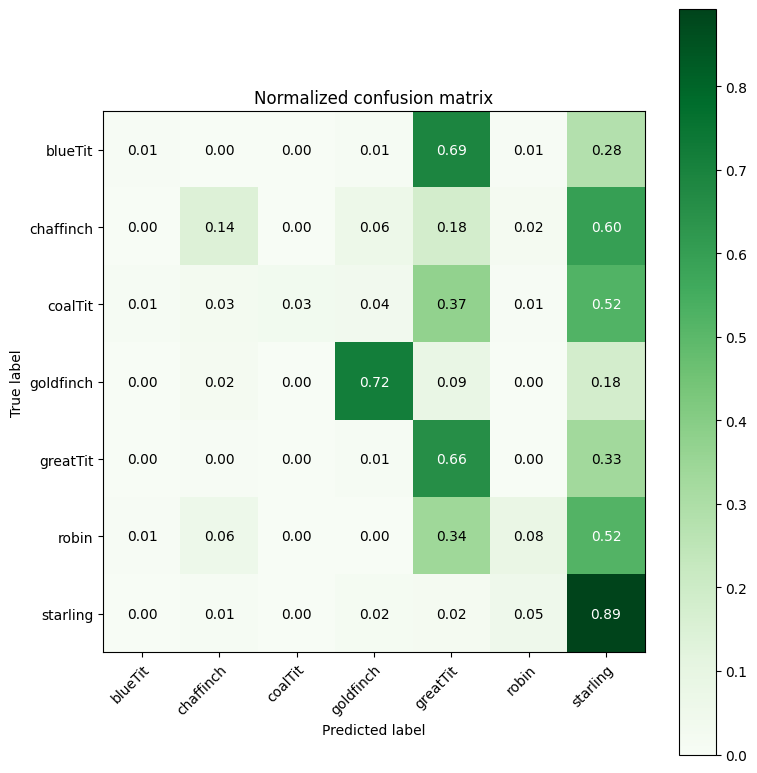

In [31]:
loaded = torch.load("aug1Model_50.tar", weights_only=True)
loadModel = load_and_prep_resnet50()
loadModel.load_state_dict(loaded["aug"])
loadModel.eval()
truel, predl = makeAll(dataloader_feeder, loadModel, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

### Finetuning

In [ ]:
unfreeze_layers(trained_model_aug1)
model_aug1, model_aug1_info = train_model(model=trained_model_aug1, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug1)

In [ ]:
torch.save({"aug1": model_aug1.state_dict(), "aug1_info": model_aug1_info, "freeze_aug1_info": trained_aug1_info},"aug1Model_60.tar")

### Round 1 results

In [ ]:
visualize_model(model_aug1, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug1_info["train_loss"], model_aug1_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug1_info["train_acc"], model_aug1_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug1, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))


In [ ]:
print(classification_report(truel, predl, target_names=class_labels))

### On feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug1, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))


## Augmentation Round 2

Add blur and colorjitter

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation2 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1), # Added
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)), # Added
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug2 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation2)
dataloader_train_aug2 = torch.utils.data.DataLoader(dataset_train_aug2, batch_size=16, shuffle=True, num_workers=2)

Load in a fresh ResNet50 that's prepped for transfer learning

In [ ]:
untrained_model_aug2 = load_and_prep_resnet50()
optimizer = torch.optim.Adam(untrained_model_aug2.parameters(), lr=0.001)
#optimizer = get_optimizer(untrained_model_aug2) 

### Training

In [ ]:
trained_model_aug2, trained_aug2_info = train_model(model=untrained_model_aug2, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug2) 

In [ ]:
torch.save({"aug": trained_model_aug2.state_dict(), "aug_info": trained_aug2_info},"aug2Model_50.tar")

### Training Results

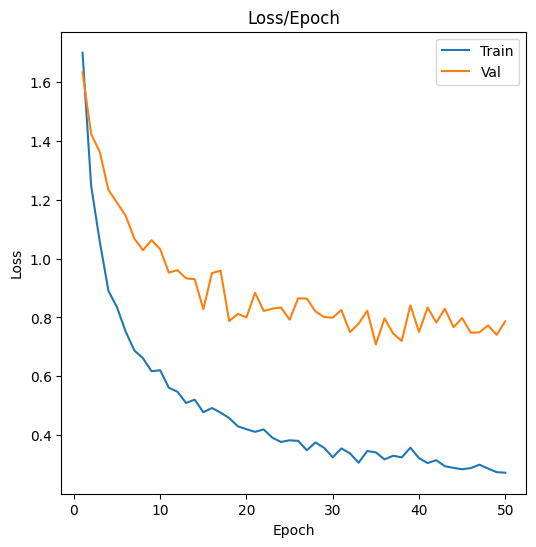

In [29]:
plot_loss(trained_aug2_info["train_loss"], trained_aug2_info["val_loss"], ["Train", "Val"])

In [30]:
truel, predl = makeAll(dataloader_test, trained_model_aug2, device)
print("Accuracy: ", (np.sum(predl==truel)/predl.size * 100))
print(classification_report(truel, predl, target_names=class_labels))

Accuracy:  72.38095238095238
              precision    recall  f1-score   support

     blueTit       0.75      0.60      0.67        15
   chaffinch       0.83      0.67      0.74        15
     coalTit       0.67      0.53      0.59        15
   goldfinch       0.80      0.80      0.80        15
    greatTit       0.55      0.73      0.63        15
       robin       0.93      0.87      0.90        15
    starling       0.65      0.87      0.74        15

    accuracy                           0.72       105
   macro avg       0.74      0.72      0.72       105
weighted avg       0.74      0.72      0.72       105



### Finetuning

In [ ]:
unfreeze_layers(trained_model_aug2)
model_aug2, model_aug2_info = train_model(model=trained_model_aug2, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug2)

In [ ]:
torch.save({"aug2": model_aug2.state_dict(), "aug2_info": model_aug2_info, "freeze_aug1_info": trained_aug2_info},"aug2Model_40.tar")

### Round 2 Results

In [ ]:
visualize_model(model_aug2, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug2_info["train_loss"], model_aug2_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug2_info["train_acc"], model_aug2_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug2, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [ ]:
class_labels = ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
print(classification_report(truel, predl, target_names=class_labels))

### On feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug2, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

## Augmentation round 3

Try without jitter

In [24]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)), # Added
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug3 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation3)
dataloader_train_aug3 = torch.utils.data.DataLoader(dataset_train_aug3, batch_size=16, shuffle=True, num_workers=2)

Load in a fresh ResNet50 that's prepped for transfer learning

In [25]:
untrained_model_aug3 = load_and_prep_resnet50()
optimizer = torch.optim.Adam(untrained_model_aug3.parameters(), lr=0.001)
# optimizer = get_optimizer(untrained_model_aug3) 

### Training
First with the frozen layers, then unfreeze for finetuning

In [26]:
trained_model_aug3, trained_aug3_info = train_model(model=untrained_model_aug3, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug3) 
torch.save({"aug": trained_model_aug3.state_dict(), "aug_info": trained_aug3_info},"aug3Model_50.tar")

Epoch 1/50
----------
Train Loss: 1.6936 Acc: 0.4551
Val Loss: 1.6172 Acc: 0.4712
Epoch time 2m 25s
----------

Epoch 2/50
----------
Train Loss: 1.2436 Acc: 0.6898
Val Loss: 1.4793 Acc: 0.5192
Epoch time 2m 25s
----------

Epoch 3/50
----------
Train Loss: 1.0596 Acc: 0.7329
Val Loss: 1.3490 Acc: 0.5769
Epoch time 2m 25s
----------

Epoch 4/50
----------
Train Loss: 0.8954 Acc: 0.7689
Val Loss: 1.2162 Acc: 0.7212
Epoch time 2m 26s
----------

Epoch 5/50
----------
Train Loss: 0.8002 Acc: 0.8036
Val Loss: 1.2031 Acc: 0.7115
Epoch time 2m 24s
----------

Epoch 6/50
----------
Train Loss: 0.7384 Acc: 0.8036
Val Loss: 1.0946 Acc: 0.7019
Epoch time 2m 25s
----------

Epoch 7/50
----------
Train Loss: 0.6827 Acc: 0.8240
Val Loss: 1.0589 Acc: 0.7115
Epoch time 2m 25s
----------

Epoch 8/50
----------
Train Loss: 0.6446 Acc: 0.8204
Val Loss: 0.9963 Acc: 0.7596
Epoch time 2m 25s
----------

Epoch 9/50
----------
Train Loss: 0.6264 Acc: 0.8263
Val Loss: 0.9773 Acc: 0.7404
Epoch time 2m 26s
----

In [ ]:
torch.save({"aug": trained_model_aug3.state_dict(), "aug_info": trained_aug3_info},"aug3Model_50.tar")

### Training Results

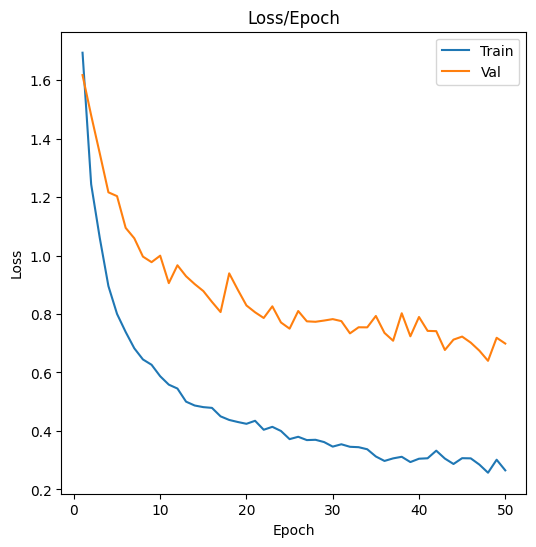

In [27]:
plot_loss(trained_aug3_info["train_loss"], trained_aug3_info["val_loss"], ["Train", "Val"])

In [28]:
truel, predl = makeAll(dataloader_test, trained_model_aug3, device)
print("Accuracy: ", (np.sum(predl==truel)/predl.size * 100))
print(classification_report(truel, predl, target_names=class_labels))

Accuracy:  78.0952380952381
              precision    recall  f1-score   support

     blueTit       1.00      0.60      0.75        15
   chaffinch       0.83      0.67      0.74        15
     coalTit       0.70      0.93      0.80        15
   goldfinch       0.85      0.73      0.79        15
    greatTit       0.62      0.67      0.65        15
       robin       0.93      0.87      0.90        15
    starling       0.71      1.00      0.83        15

    accuracy                           0.78       105
   macro avg       0.81      0.78      0.78       105
weighted avg       0.81      0.78      0.78       105



### Finetuning

In [ ]:
unfreeze_layers(trained_model_aug3)
model_aug3, model_aug3_info = train_model(model=trained_model_aug3, optimizer=optimizer, num_epoch=50, train=dataloader_train_aug3)

In [ ]:
torch.save({"aug3": model_aug3.state_dict(), "aug3_info": model_aug3_info, "freeze_aug3_info": trained_aug3_info},"aug3Model_40.tar")

### Round 3 Results

In [ ]:
visualize_model(model_aug3, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug3_info["train_loss"], model_aug3_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug3_info["train_acc"], model_aug3_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug3, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [ ]:
class_labels = ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
print(classification_report(truel, predl, target_names=class_labels))

### On Feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug3, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))